In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import os

In [2]:
# Connect to / create database
conn = sqlite3.connect('dataverse.db')
c = conn.cursor()

2a) What are the best times and days of the week to minimise delays each year?

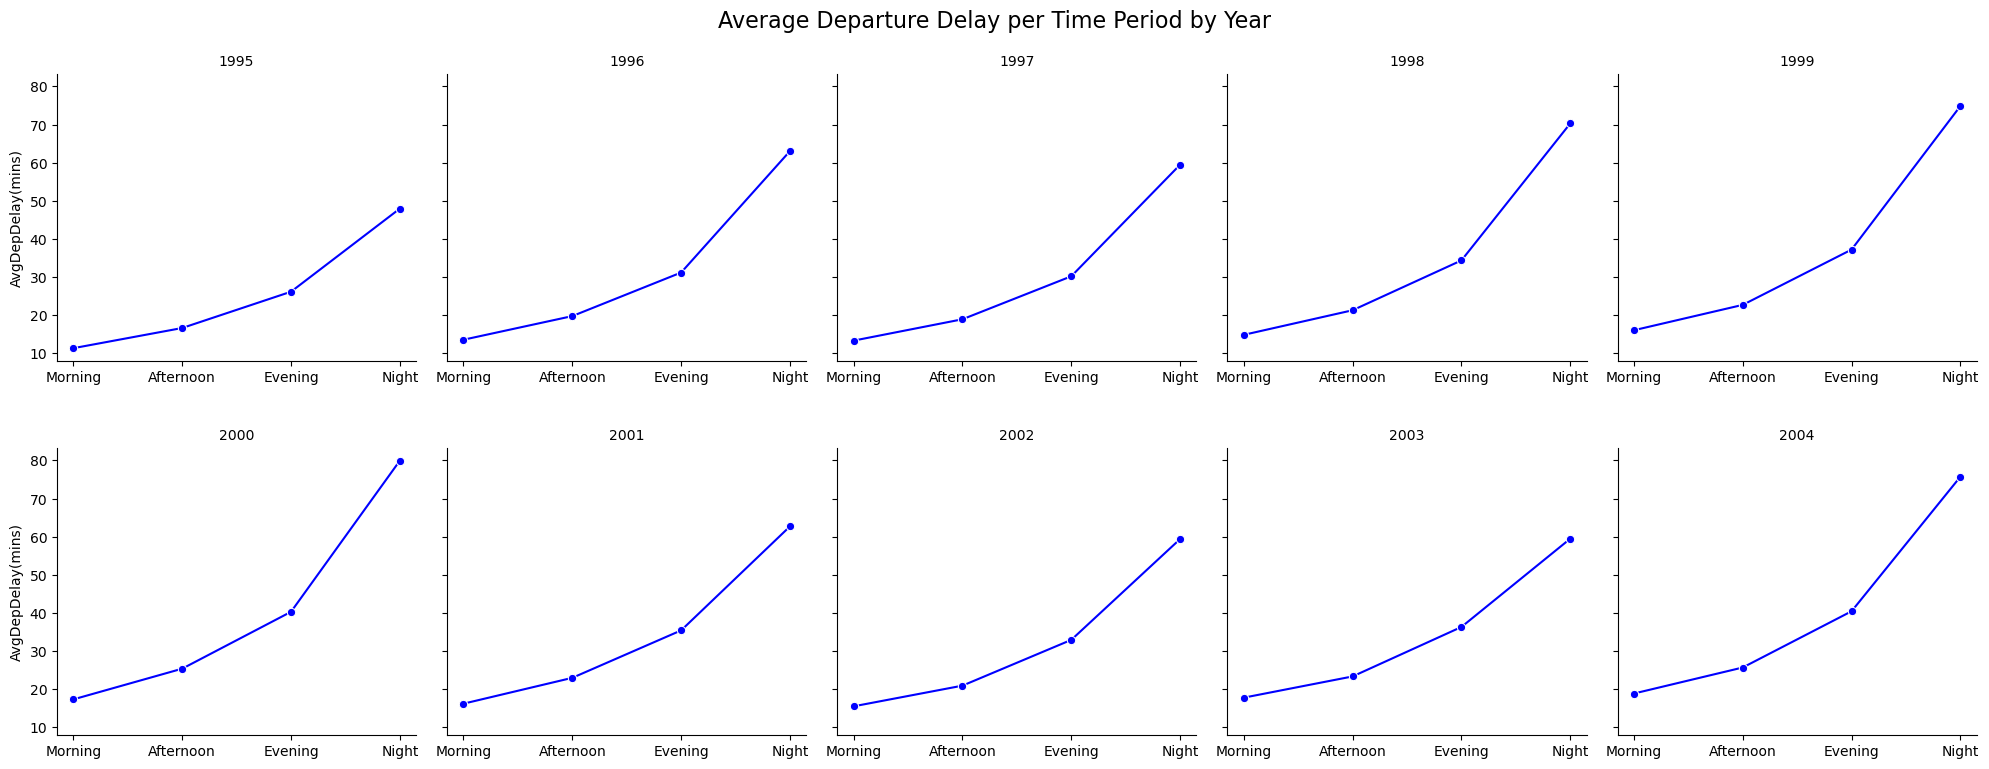

In [3]:
# Query to find average departure delay for each time period of the day in minutes.
c.execute('''
WITH TimeofDay AS (
    SELECT Year,
        CASE
            WHEN Time >= 0 AND Time < 600 THEN 'Night'
            WHEN Time >= 600 AND Time < 1200 THEN 'Morning'
            WHEN Time >= 1200 AND Time < 1800 THEN 'Afternoon'
            WHEN Time >= 1800 AND Time <= 2400 THEN 'Evening'
            ELSE 'Invalid'
        END AS TimePeriod, DepDelay
    FROM
        (
        SELECT Year, DepTime AS Time, DepDelay
        FROM flights
        WHERE Cancelled = 0 AND Diverted = 0 AND DepDelay > 0
        ) AS subquery
)
SELECT Year, TimePeriod, AVG(DepDelay) AS AvgDepDelay
FROM TimeofDay
WHERE TimePeriod != 'Invalid'
GROUP BY Year, TimePeriod;
''')

# Put query into dataframe
a = c.fetchall()
adf = pd.DataFrame(a, columns = ['Year', 'TimePeriod', 'AvgDepDelay'])
sort_adf = adf.sort_values(by = 'AvgDepDelay', ascending = True)
# print(sort_adf.to_string(index = False))

# Plotting the graph
z = sns.FacetGrid(sort_adf, col = "Year", col_wrap = 5, height = 4)
z.map(sns.lineplot, "TimePeriod", "AvgDepDelay", marker = 'o', color = 'blue')
z.set_titles("{col_name}")
z.set_axis_labels('' ,'AvgDepDelay(mins)')
plt.subplots_adjust(top = 0.9, hspace = 0.3)
z.fig.suptitle('Average Departure Delay per Time Period by Year', fontsize = 16)
for ax in z.axes.flat:
    ax.xaxis.set_tick_params(labelbottom = True)
plt.show()

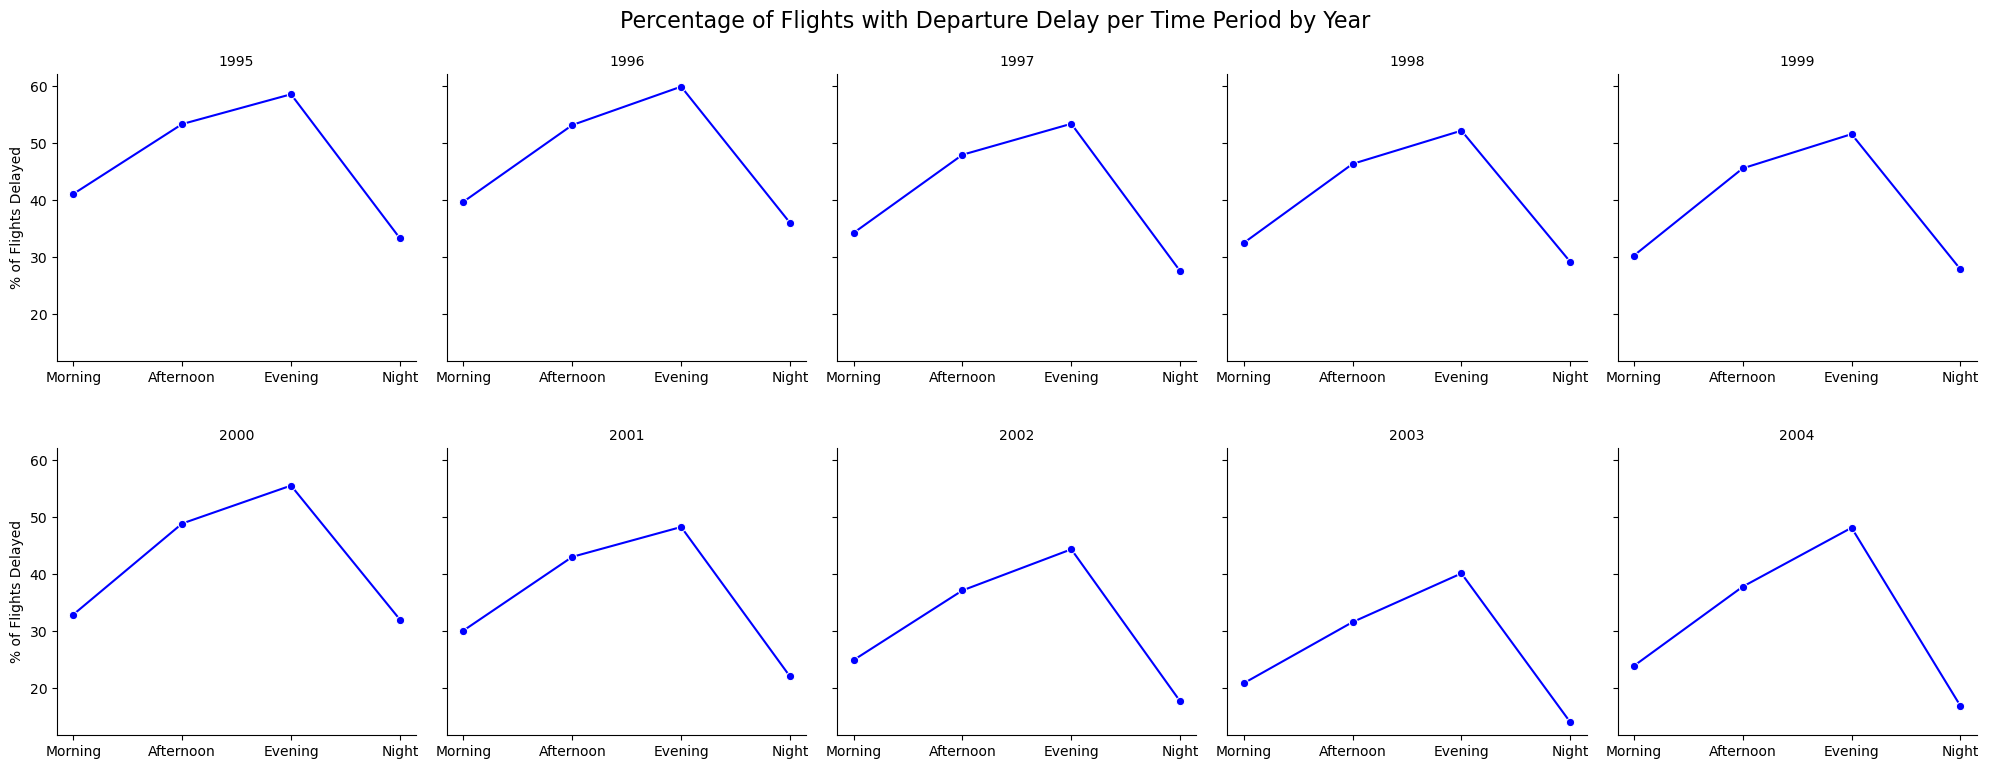

In [4]:
# Query to find percentage of delayed flights for each time period of the day.
c.execute('''
WITH TimeofDay AS (
    SELECT Year,
        CASE
            WHEN Time >= 0 AND Time < 600 THEN 'Night'
            WHEN Time >= 600 AND Time < 1200 THEN 'Morning'
            WHEN Time >= 1200 AND Time < 1800 THEN 'Afternoon'
            WHEN Time >= 1800 AND Time <= 2400 THEN 'Evening'
            ELSE 'Invalid'
        END AS TimePeriod, DepDelay
    FROM
        (
        SELECT Year, DepTime AS Time, DepDelay
        FROM flights
        WHERE Cancelled = 0 AND Diverted = 0 
        ) AS subquery
)
SELECT Year, TimePeriod, (COUNT(CASE WHEN DepDelay > 0 THEN 1 END) * 100.0 / COUNT(*)) AS 
    PercentDelay
FROM TimeofDay
WHERE TimePeriod != 'Invalid'
GROUP BY Year, TimePeriod;
''')

# Put query into dataframe
b = c.fetchall()
bdf = pd.DataFrame(b, columns = ['Year', 'TimePeriod', 'PercentDelay'])
custom_order = ['Morning', 'Afternoon', 'Evening', 'Night']
bdf['TimePeriod'] = pd.Categorical(bdf['TimePeriod'], categories = custom_order, ordered = True)
sort_bdf = bdf.sort_values(by = ['TimePeriod', 'PercentDelay'], ascending = True)
# print(sort_bdf.to_string(index = False))

# Plotting the graph
y = sns.FacetGrid(sort_bdf, col = "Year", col_wrap = 5, height = 4)
y.map(sns.lineplot, "TimePeriod", "PercentDelay", marker = 'o', color = 'blue')
y.set_titles("{col_name}")
y.set_axis_labels('' ,'% of Flights Delayed')
plt.subplots_adjust(top = 0.9, hspace = 0.3)
y.fig.suptitle('Percentage of Flights with Departure Delay per Time Period by Year', fontsize = 16)
for ax in y.axes.flat:
    ax.xaxis.set_tick_params(labelbottom = True)
plt.show()

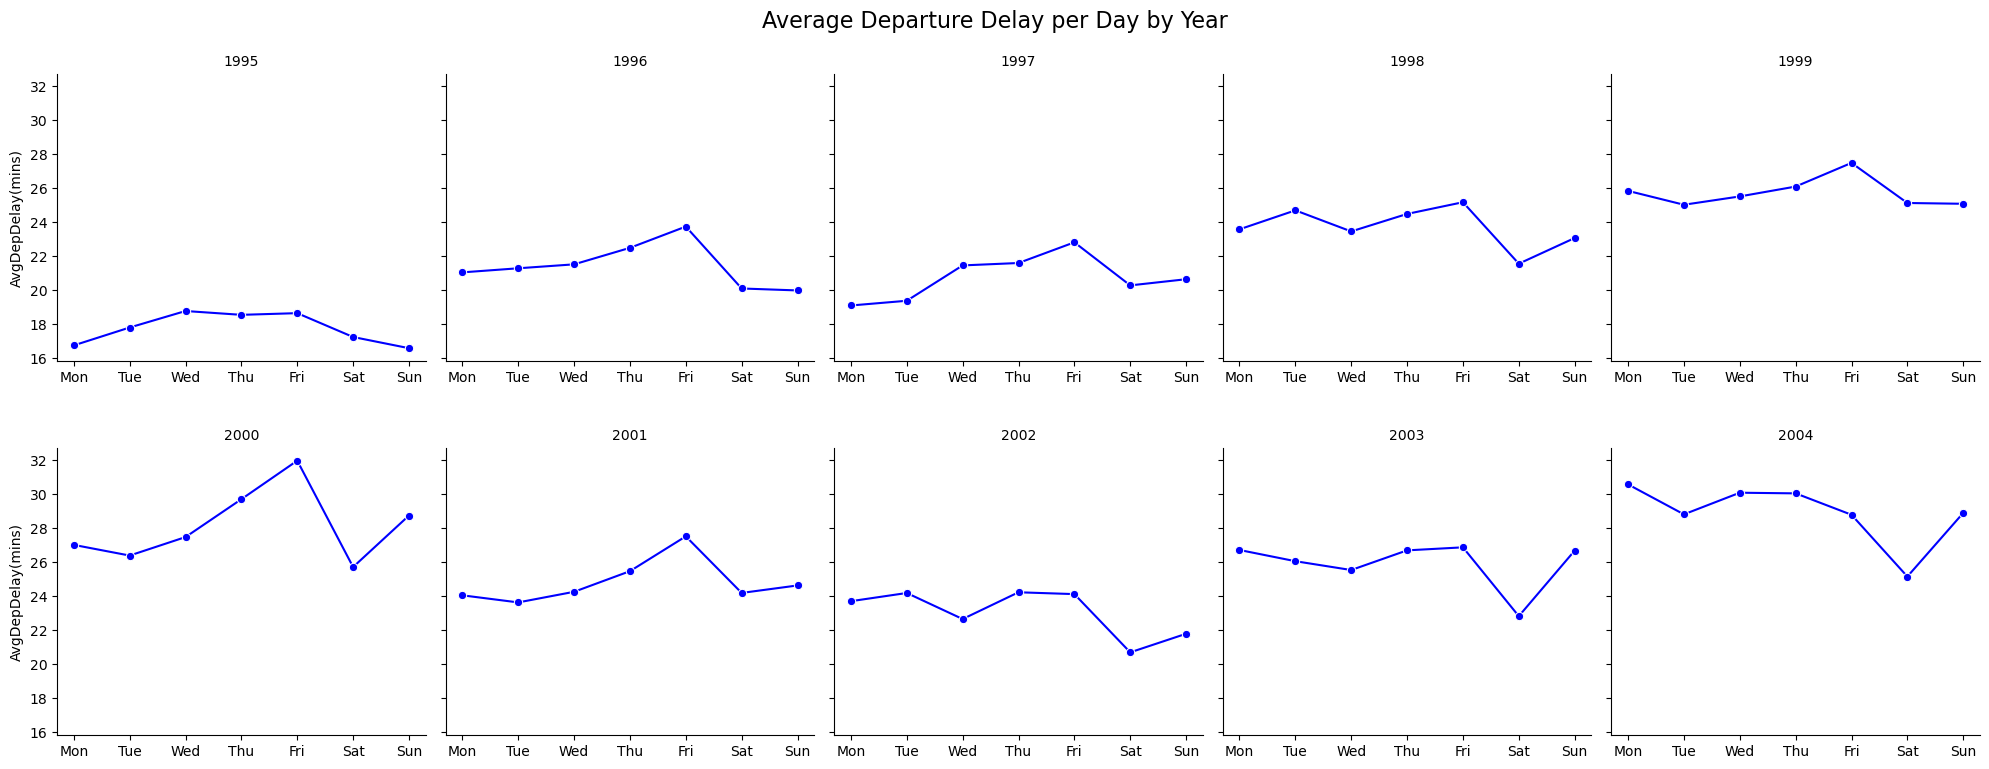

In [5]:
# Query to find average delay per day in minutes.
c.execute('''
SELECT Year,
    CASE
        WHEN DayofWeek = 1 THEN 'Mon' 
        WHEN DayofWeek = 2 THEN 'Tue'
        WHEN DayofWeek = 3 THEN 'Wed'
        WHEN DayofWeek = 4 THEN 'Thu'
        WHEN DayofWeek = 5 THEN 'Fri'
        WHEN DayofWeek = 6 THEN 'Sat'
        WHEN DayofWeek = 7 THEN 'Sun'
    END AS DayofWeek,
    AVG(DepDelay) AS AvgDepDelay
FROM flights
WHERE Cancelled = 0 AND Diverted = 0 AND DepDelay > 0
GROUP BY Year, DayofWeek;
''')

# Put query into dataframe
d = c.fetchall()
ddf = pd.DataFrame(d, columns = ['Year', 'DayofWeek', 'AvgDepDelay'])
custom_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ddf['DayofWeek'] = pd.Categorical(ddf['DayofWeek'], categories = custom_order, ordered = True)
sort_ddf = ddf.sort_values(by = ['AvgDepDelay', 'DayofWeek'], ascending = True)
# print(sort_ddf.to_string(index = False))

# Plotting the graph
x = sns.FacetGrid(sort_ddf, col = "Year", col_wrap = 5, height = 4)
x.map(sns.lineplot, "DayofWeek", "AvgDepDelay", marker = 'o', color = 'blue')
x.set_titles("{col_name}")
x.set_axis_labels('' ,'AvgDepDelay(mins)')
plt.subplots_adjust(top = 0.9, hspace = 0.3)
x.fig.suptitle('Average Departure Delay per Day by Year', fontsize = 16)
for ax in x.axes.flat:
    ax.xaxis.set_tick_params(labelbottom = True)
plt.show()

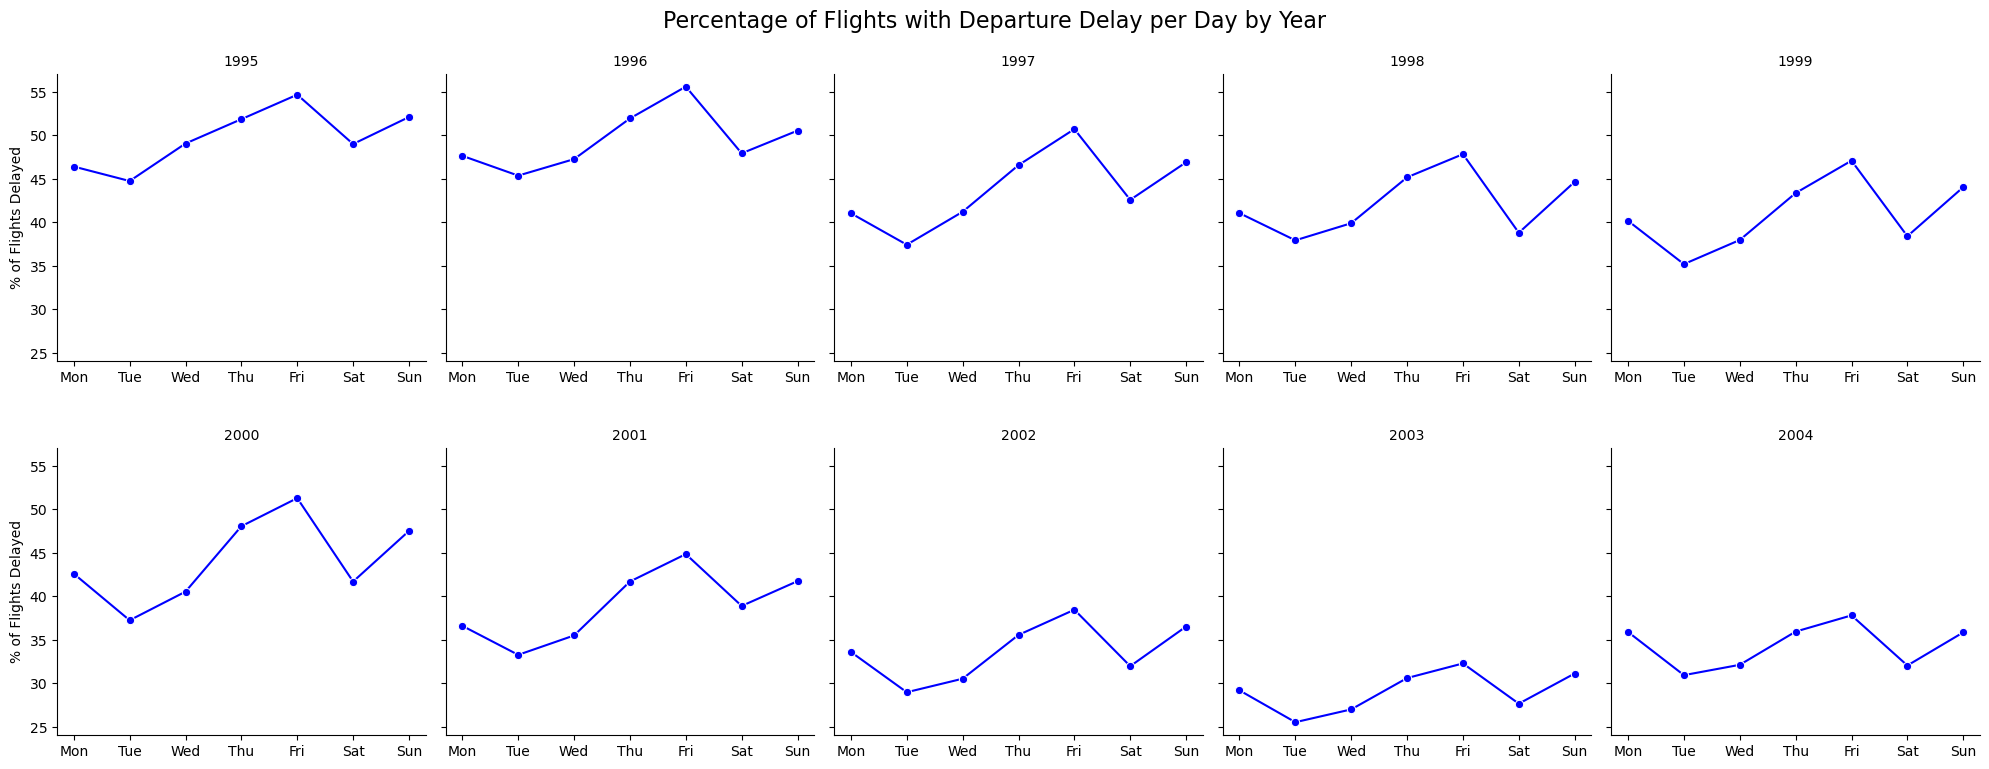

In [6]:
# Query to find percentage of delayed flights per day
c.execute('''
SELECT Year,
    CASE
        WHEN DayofWeek = 1 THEN 'Mon'
        WHEN DayofWeek = 2 THEN 'Tue'
        WHEN DayofWeek = 3 THEN 'Wed'
        WHEN DayofWeek = 4 THEN 'Thu'
        WHEN DayofWeek = 5 THEN 'Fri'
        WHEN DayofWeek = 6 THEN 'Sat'
        WHEN DayofWeek = 7 THEN 'Sun'
    END AS DayofWeek,
    (COUNT(CASE WHEN DepDelay > 0 THEN 1 END) * 100.0 / COUNT(*)) AS PercentDelay
FROM flights
WHERE Cancelled = 0 AND Diverted = 0
GROUP BY Year, DayofWeek;
''')

# Put query into dataframe
e = c.fetchall()
edf = pd.DataFrame(e, columns = ['Year', 'DayofWeek', 'PercentDelay'])
custom_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
edf['DayofWeek'] = pd.Categorical(edf['DayofWeek'], categories = custom_order, ordered = True)
sort_edf = edf.sort_values(by = ['PercentDelay', 'DayofWeek'], ascending = True)
# print(sort_edf.to_string(index = False))

# Plotting the graph
w = sns.FacetGrid(sort_edf, col = "Year", col_wrap = 5, height = 4)
w.map(sns.lineplot, "DayofWeek", "PercentDelay", marker = 'o', color = 'blue')
w.set_titles("{col_name}")
w.set_axis_labels('' ,'% of Flights Delayed')
plt.subplots_adjust(top = 0.9, hspace = 0.3)
w.fig.suptitle('Percentage of Flights with Departure Delay per Day by Year', fontsize = 16)
for ax in w.axes.flat:
    ax.xaxis.set_tick_params(labelbottom = True)
plt.show()

2b) Evaluate whether older planes suffer more delays on a year-to-year basis.

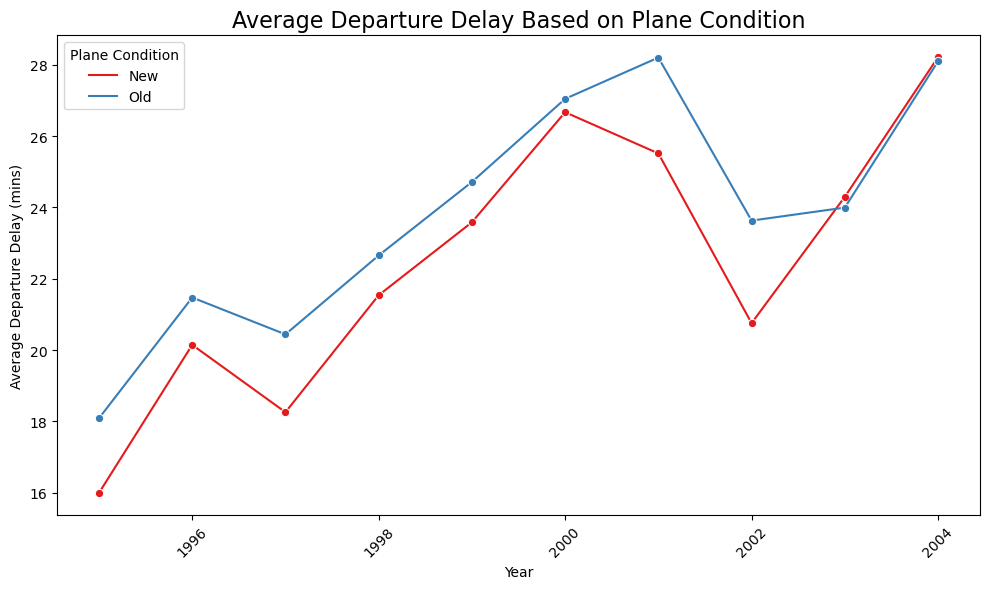

In [7]:
# Query to find average delays in minutes based on plane condition
# Data type  for 'year' in planes table was changed to integer in the DB using DB Browser. Was undefined at first.
c.execute('''
SELECT flights.Year,
    CASE
        WHEN planes.year <= 1988 THEN 'Old'
        ELSE 'New'
    END AS PlaneCondition,
    AVG(DepDelay) AS AvgDepDelay
FROM flights LEFT JOIN planes ON flights.TailNum = planes.tailnum
WHERE planes.year != 'None' AND planes.year != 0 AND planes.year IS NOT NULL AND flights.DepDelay > 0 
    AND 
flights.Cancelled = 0 AND flights.Diverted = 0
GROUP BY flights.Year, PlaneCondition;
''')

# Put query into dataframe
f = c.fetchall()
fdf = pd.DataFrame(f, columns = ['Year', 'PlaneCondition', 'AvgDepDelay'])
sort_fdf = fdf.sort_values(by = 'PlaneCondition')
# print(sort_fdf.to_string(index = False))

# Plotting the graph
sort_fdf['Year'] = pd.Categorical(sort_fdf['Year'], categories = sorted(sort_fdf['Year'].unique()))
plt.figure(figsize = (10, 6))
sns.lineplot(data = sort_fdf, x = 'Year', y = 'AvgDepDelay', hue = 'PlaneCondition', marker = 'o', 
             palette = 'Set1')
plt.title('Average Departure Delay Based on Plane Condition', fontsize = 16)
plt.xlabel('Year')
plt.ylabel('Average Departure Delay (mins)')
plt.legend(title = 'Plane Condition')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

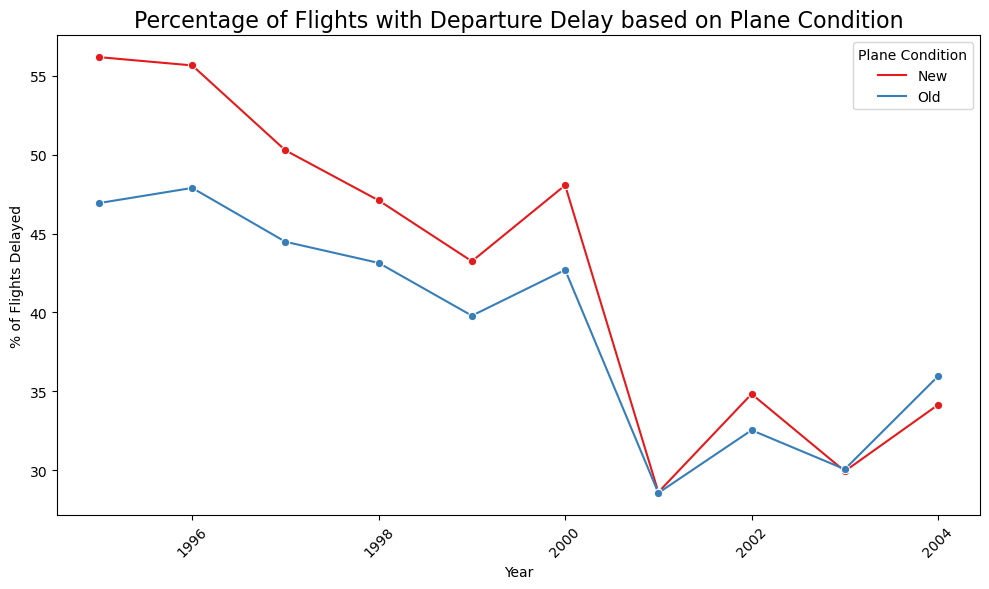

In [8]:
# Query to find percentage of delayed flights based on plane condition
# Data type for 'year' in planes table was changed to integer in the DB using DB Browser. Was undefined at first.
c.execute('''
SELECT flights.Year,
    CASE
        WHEN planes.year <= 1988 THEN 'Old'
        ELSE 'New'
    END AS PlaneCondition,
    (COUNT(CASE WHEN DepDelay > 0 THEN 1 END) * 100.0 / COUNT(*)) AS PercentDelay
FROM flights LEFT JOIN planes ON flights.TailNum = planes.tailnum
WHERE planes.year != 'None' AND planes.year != 0 AND planes.year IS NOT NULL AND 
flights.Cancelled = 0 AND flights.Diverted = 0
GROUP BY flights.Year, PlaneCondition;
''')

# Put query into dataframe
g = c.fetchall()
gdf = pd.DataFrame(g, columns = ['Year', 'PlaneCondition', 'PercentDelay'])
sort_gdf = gdf.sort_values(by = 'PlaneCondition')
# print(sort_gdf.to_string(index = False))

# Plotting the graph
sort_gdf['Year'] = pd.Categorical(sort_gdf['Year'], categories = sorted(sort_gdf['Year'].unique()))
plt.figure(figsize = (10, 6))
sns.lineplot(data = sort_gdf, x = 'Year', y = 'PercentDelay', hue = 'PlaneCondition', marker = 'o', 
             palette = 'Set1')
plt.title('Percentage of Flights with Departure Delay based on Plane Condition', fontsize = 16)
plt.xlabel('Year')
plt.ylabel('% of Flights Delayed')
plt.legend(title = 'Plane Condition')
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

In [10]:
conn.close()